<a href="https://colab.research.google.com/github/PravalikaMuthoju/INTERNSHIP-PROJECTS/blob/main/NEW_RL_JSSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 0, Total Reward: -5733.00, Makespan: 704, Best Makespan: 704
Episode 100, Total Reward: -5699.00, Makespan: 704, Best Makespan: 704
Episode 200, Total Reward: -5704.00, Makespan: 704, Best Makespan: 704
Episode 300, Total Reward: -5704.00, Makespan: 704, Best Makespan: 704
Episode 400, Total Reward: -5733.00, Makespan: 704, Best Makespan: 704
Episode 500, Total Reward: -5704.00, Makespan: 704, Best Makespan: 704
Episode 600, Total Reward: -5704.00, Makespan: 704, Best Makespan: 704
Episode 700, Total Reward: -5699.00, Makespan: 704, Best Makespan: 704
Episode 800, Total Reward: -5704.00, Makespan: 704, Best Makespan: 704
Episode 900, Total Reward: -5699.00, Makespan: 704, Best Makespan: 704
Episode 1000, Total Reward: -5733.00, Makespan: 704, Best Makespan: 704
Episode 1100, Total Reward: -5704.00, Makespan: 704, Best Makespan: 704
Episode 1200, Total Reward: -5704.00, Makespan: 704, Best Makespan: 704
Episode 1300, Total Reward: -5699.00, Makespan: 704, Best Makespan: 704
Epis

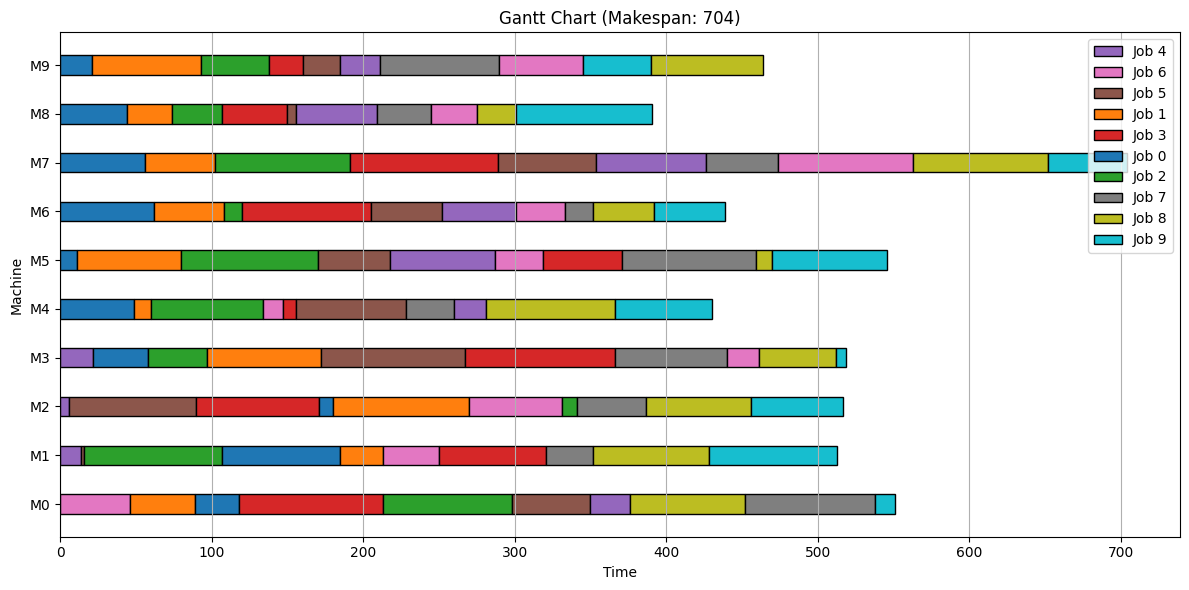

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

class JSSPEnvironment:
    """Job Shop Scheduling Problem environment."""
    def __init__(self, jobs, num_machines):
        """
        Initialize JSSP environment.

        Args:
            jobs: List of jobs, each a list of (machine, duration) tuples.
            num_machines: Number of machines available.
        """
        self.jobs = jobs
        self.num_jobs = len(jobs)
        self.num_machines = num_machines
        self.state = None
        self.current_time = 0
        self.job_progress = None
        self.machine_free_time = None
        self.makespan = 0
        self._validate_input()
        self.reset()

    def _validate_input(self):
        """Validate the jobs and num_machines input."""
        if not self.jobs:
            raise ValueError("Jobs list cannot be empty.")
        if self.num_machines <= 0:
            raise ValueError("Number of machines must be positive.")
        for job in self.jobs:
            if not job:
                raise ValueError("Each job must have at least one operation.")
            for machine, duration in job:
                if not isinstance(machine, int) or machine < 0 or machine >= self.num_machines:
                    raise ValueError(f"Invalid machine ID: {machine}. Must be in [0, {self.num_machines-1}].")
                if not isinstance(duration, (int, float)) or duration <= 0:
                    raise ValueError(f"Invalid duration: {duration}. Must be positive.")

    def reset(self):
        """Reset environment to initial state."""
        self.current_time = 0
        self.job_progress = [0] * self.num_jobs
        self.machine_free_time = [0] * self.num_machines
        self.makespan = 0
        self.state = (tuple(self.job_progress), tuple(self.machine_free_time))
        return self.state

    def get_available_actions(self):
        """Return list of jobs that can be scheduled next."""
        return [job_id for job_id in range(self.num_jobs) if self.job_progress[job_id] < len(self.jobs[job_id])]

    def step(self, action):
        """
        Schedule a job's next operation.

        Args:
            action: Job ID to schedule.

        Returns:
            next_state, reward, done
        """
        if action not in self.get_available_actions():
            return self.state, -100, False

        operation_idx = self.job_progress[action]
        machine, duration = self.jobs[action][operation_idx]
        machine = int(machine)  # Ensure machine is an integer

        start_time = max(self.current_time, self.machine_free_time[machine])
        end_time = start_time + duration
        self.machine_free_time[machine] = end_time
        self.job_progress[action] += 1
        self.current_time = min(self.machine_free_time + [float('inf')])

        self.makespan = max(self.makespan, end_time)

        done = all(self.job_progress[j] >= len(self.jobs[j]) for j in range(self.num_jobs))

        reward = -duration if not done else -self.makespan

        self.state = (tuple(self.job_progress), tuple(self.machine_free_time))

        return self.state, reward, done

class QLearningAgent:
    """Q-Learning agent for JSSP."""
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon_start=0.5, epsilon_end=0.01, epsilon_decay=0.995):
        """
        Initialize Q-Learning agent.

        Args:
            env: JSSPEnvironment instance.
            learning_rate: Learning rate for Q-value updates.
            discount_factor: Discount factor for future rewards.
            epsilon_start: Initial epsilon for epsilon-greedy policy.
            epsilon_end: Final epsilon after decay.
            epsilon_decay: Decay rate for epsilon.
        """
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.q_table = {}

    def get_q_value(self, state, action):
        """Get Q-value for (state, action) pair."""
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        """Update Q-value using Q-Learning formula."""
        available_actions = self.env.get_available_actions()
        max_q = max([self.get_q_value(next_state, a) for a in available_actions], default=0)
        current_q = self.get_q_value(state, action)
        new_q = current_q + self.lr * (reward + self.gamma * max_q - current_q)
        self.q_table[(state, action)] = new_q

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy."""
        available_actions = self.env.get_available_actions()
        if not available_actions:
            return None
        if random.random() < self.epsilon:
            return random.choice(available_actions)
        q_values = {a: self.get_q_value(state, a) for a in available_actions}
        return max(q_values, key=q_values.get)

    def decay_epsilon(self):
        """Decay epsilon for exploration-exploitation trade-off."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

def load_jssp_dataset(csv_file):
    """Load and parse a JSSP dataset from a CSV file."""
    try:
        df = pd.read_csv(csv_file)
        required_columns = ['Job ID', 'Operation', 'Machine', 'Processing Time']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"CSV file must contain columns: {required_columns}")

        # Convert Machine IDs (e.g., 'M0' to 0)
        df['Machine'] = df['Machine'].str.replace('M', '').astype(int)

        # Determine number of jobs
        num_jobs = df['Job ID'].max() + 1
        jobs = [[] for _ in range(num_jobs)]

        # Parse jobs
        for _, row in df.sort_values(['Job ID', 'Operation']).iterrows():
            job_id = int(row['Job ID'])
            machine = int(row['Machine'])
            duration = int(row['Processing Time'])
            jobs[job_id].append((machine, duration))

        # Validate jobs
        if not jobs or any(not job for job in jobs):
            raise ValueError("Invalid dataset: Empty jobs or missing operations.")

        return jobs
    except FileNotFoundError:
        raise FileNotFoundError(f"CSV file not found: {csv_file}")
    except Exception as e:
        raise ValueError(f"Error parsing CSV file {csv_file}: {e}")

def train_jssp(csv_file, num_episodes=5000):
    """Train the Q-Learning agent on the JSSP dataset."""
    try:
        jobs = load_jssp_dataset(csv_file)
        num_machines = max(max(job, key=lambda x: x[0])[0] for job in jobs) + 1
        env = JSSPEnvironment(jobs, num_machines)
        agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.9,
                             epsilon_start=0.5, epsilon_end=0.01, epsilon_decay=0.995)

        best_makespan = float('inf')
        for episode in range(num_episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = agent.choose_action(state)
                if action is None:
                    break
                next_state, reward, done = env.step(action)
                agent.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
            agent.decay_epsilon()
            best_makespan = min(best_makespan, env.makespan)
            if episode % 100 == 0:
                print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Makespan: {env.makespan}, Best Makespan: {best_makespan}")

        return agent, env
    except Exception as e:
        print(f"Training error: {e}")
        raise

def test_schedule(agent, env):
    """Test the trained agent and return the schedule."""
    try:
        state = env.reset()
        schedule = []
        done = False
        while not done:
            action = agent.choose_action(state)
            if action is None:
                break
            job_id = action
            operation_idx = env.job_progress[job_id]
            machine, duration = env.jobs[job_id][operation_idx]
            start_time = max(env.current_time, env.machine_free_time[machine])
            schedule.append((job_id, operation_idx, machine, start_time, duration))
            state, _, done = env.step(action)

        print("\nOptimal Schedule:")
        for job_id, op_idx, machine, start, duration in schedule:
            print(f"Job {job_id}, Operation {op_idx}: Machine {machine}, Start {start}, Duration {duration}")
        print(f"Makespan: {env.makespan}")

        return schedule, env.makespan
    except Exception as e:
        print(f"Testing error: {e}")
        raise

def plot_gantt_chart(schedule, makespan, num_machines):
    """Plot a Gantt chart for the schedule."""
    try:
        plt.figure(figsize=(12, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, max(job_id for job_id, _, _, _, _ in schedule) + 1))
        for job_id, op_idx, machine, start, duration in schedule:
            plt.barh(machine, duration, left=start, height=0.4,
                    color=colors[job_id], edgecolor='black',
                    label=f"Job {job_id}" if op_idx == 0 else "")
        plt.xlabel("Time")
        plt.ylabel("Machine")
        plt.title(f"Gantt Chart (Makespan: {makespan})")
        plt.yticks(range(num_machines), [f"M{i}" for i in range(num_machines)])
        plt.grid(True, axis='x')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting Gantt chart: {e}")

if __name__ == "__main__":
    try:
        # Specify the CSV file path
        csv_file = "FT10_Dataset.csv"  # Change to "FT20_Dataset.csv" if using FT20
        agent, env = train_jssp(csv_file, num_episodes=5000)
        schedule, makespan = test_schedule(agent, env)
        plot_gantt_chart(schedule, makespan, env.num_machines)
    except Exception as e:
        print(f"Main execution error: {e}")

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os

class JSSPEnvironment:
    def __init__(self, jobs, num_machines):
        self.jobs = jobs
        self.num_jobs = len(jobs)
        self.num_machines = num_machines
        self.reset()

    def reset(self):
        self.current_time = 0
        self.job_progress = [0] * self.num_jobs
        self.machine_free_time = [0] * self.num_machines
        self.makespan = 0
        self.state = (tuple(self.job_progress), tuple(self.machine_free_time))
        return self.state

    def get_available_actions(self):
        return [job_id for job_id in range(self.num_jobs) if self.job_progress[job_id] < len(self.jobs[job_id])]

    def step(self, action):
        if action not in self.get_available_actions():
            return self.state, -100, False

        operation_idx = self.job_progress[action]
        machine, duration = self.jobs[action][operation_idx]

        start_time = max(self.current_time, self.machine_free_time[machine])
        end_time = start_time + duration
        self.machine_free_time[machine] = end_time
        self.job_progress[action] += 1

        self.makespan = max(self.makespan, end_time)
        self.current_time = min(self.machine_free_time)

        done = all(self.job_progress[j] >= len(self.jobs[j]) for j in range(self.num_jobs))

        # Reward encourages short makespan and penalizes idle time
        reward = -((end_time - start_time) + (self.makespan / 100))

        self.state = (tuple(self.job_progress), tuple(self.machine_free_time))
        return self.state, reward, done

class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon_start=0.5, epsilon_end=0.01, epsilon_decay=0.995):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        available_actions = self.env.get_available_actions()
        max_q = max([self.get_q_value(next_state, a) for a in available_actions], default=0)
        current_q = self.get_q_value(state, action)
        new_q = current_q + self.lr * (reward + self.gamma * max_q - current_q)
        self.q_table[(state, action)] = new_q

    def choose_action(self, state, explore=True):
        available_actions = self.env.get_available_actions()
        if not available_actions:
            return None
        if explore and random.random() < self.epsilon:
            return random.choice(available_actions)
        q_values = {a: self.get_q_value(state, a) for a in available_actions}
        return max(q_values, key=q_values.get)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

def load_ft10_dataset(csv_file):
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"Dataset not found: {csv_file}")

    df = pd.read_csv(csv_file)
    df['Machine'] = df['Machine'].str.replace('M', '').astype(int)
    num_jobs = df['Job ID'].max() + 1
    jobs = [[] for _ in range(num_jobs)]
    for _, row in df.sort_values(['Job ID', 'Operation']).iterrows():
        job_id = int(row['Job ID'])
        machine = int(row['Machine'])
        duration = int(row['Processing Time'])
        jobs[job_id].append((machine, duration))
    return jobs

def train_jssp(csv_file, num_episodes=5000, patience=1000):
    jobs = load_ft10_dataset(csv_file)
    num_machines = max(max(job, key=lambda x: x[0])[0] for job in jobs) + 1
    env = JSSPEnvironment(jobs, num_machines)
    agent = QLearningAgent(env)

    best_makespan = float('inf')
    no_improvement_counter = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state, explore=True)
            if action is None:
                break
            next_state, reward, done = env.step(action)
            agent.update_q_value(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        if env.makespan < best_makespan:
            best_makespan = env.makespan
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        agent.decay_epsilon()

        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Makespan: {env.makespan}, Best Makespan: {best_makespan}")

        if no_improvement_counter >= patience:
            print(f"Early stopping at episode {episode} (no improvement for {patience} episodes)")
            break

    return agent, env

def test_schedule(agent, env):
    state = env.reset()
    schedule = []
    done = False

    while not done:
        action = agent.choose_action(state, explore=False)
        if action is None:
            break
        job_id = action
        operation_idx = env.job_progress[job_id]
        machine, duration = env.jobs[job_id][operation_idx]
        start_time = max(env.current_time, env.machine_free_time[machine])
        schedule.append((job_id, operation_idx, machine, start_time, duration))
        state, _, done = env.step(action)

    print("\nOptimal Schedule:")
    for job_id, op_idx, machine, start, duration in schedule:
        print(f"Job {job_id}, Operation {op_idx}: Machine {machine}, Start {start}, Duration {duration}")
    print(f"Makespan: {env.makespan}")

    return schedule, env.makespan

def plot_gantt_chart(schedule, makespan, num_machines):
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # More colors for more jobs
    for job_id, op_idx, machine, start, duration in schedule:
        plt.barh(machine, duration, left=start, height=0.4,
                 color=colors[job_id % 20], edgecolor='black',
                 label=f"Job {job_id}" if op_idx == 0 else "")
    plt.xlabel("Time")
    plt.ylabel("Machine")
    plt.title(f"Gantt Chart (Makespan: {makespan})")
    plt.yticks(range(num_machines), [f"M{i}" for i in range(num_machines)])
    plt.grid(True, axis='x')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    csv_file = "/content/FT20_Dataset.csv"
    agent, env = train_jssp(csv_file, num_episodes=5000, patience=1500)
    schedule, makespan = test_schedule(agent, env)
    plot_gantt_chart(schedule, makespan, env.num_machines)


FileNotFoundError: Dataset not found: /content/FT20_Dataset.csv


🔧 Job-Machine-Time Assignments:
 Job ID  Operation  Machine  Start  End
      0          0        0      0   29
      2          0        1      0   91
      3          0        2      0   81
      1          0        0     29   72
      6          0        0     72  118
      5          0        2     81  165
      4          0        1     91  105
      7          0        1    105  136
      8          0        0    118  194
      9          0        1    136  221
      1          1        2    165  255
      1          2        3    166  241
      1          3        4    167  178
      1          4        5    168  237
      2          1        0    194  279
      0          1        1    221  299
      1          6        6    222  268
      1          7        7    223  269
      1          8        9    224  296
      1          9        8    225  255
      4          4        5    237  306
      4          5        4    238  259
      4          2        3    241  263
      4

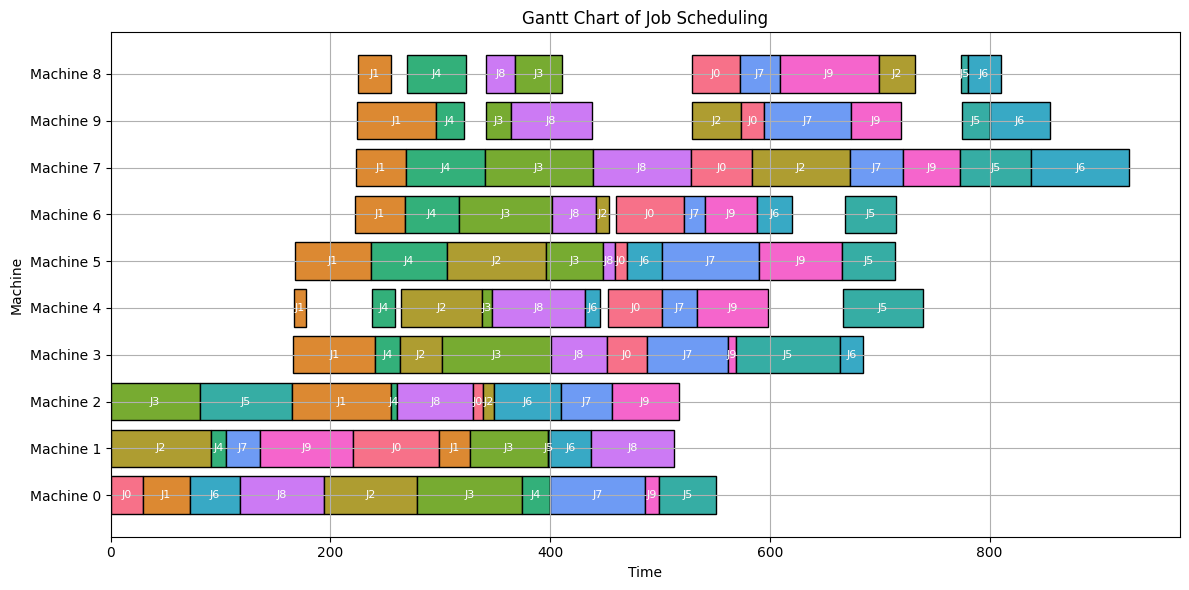

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
import seaborn as sns
import pickle

# Load dataset (e.g., FT06 from CSV or ZIP)
df = pd.read_csv("/content/FT10_Dataset.csv")
df["Machine"] = df["Machine"].apply(lambda x: int(x[1:]))  # Convert 'M1' to 1, etc.

# Extract parameters
num_jobs = df["Job ID"].nunique()
num_machines = df["Machine"].nunique()
operations_per_job = df.groupby("Job ID")["Operation"].max().iloc[0] + 1

# Build job operation structure
job_operations = defaultdict(list)
for _, row in df.iterrows():
    job_operations[int(row["Job ID"])].append((int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])))
for job in job_operations:
    job_operations[job].sort(key=lambda x: x[0])

# Q-Learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.2
episodes = 500

Q = defaultdict(float)

def get_available_jobs(job_progress):
    return [j for j in range(num_jobs) if job_progress[j] < operations_per_job]

def get_feasible_machines(job_progress, machine_status, t):
    feasible = []
    for job in get_available_jobs(job_progress):
        op_num = job_progress[job]
        _, m, _ = job_operations[job][op_num]
        if machine_status[m] <= t:
            feasible.append((job, m))
    return feasible

def get_next_action(state):
    feasible = get_feasible_machines(state[0], state[1], 0)
    feasible_jobs = list(set([job for job, _ in feasible]))
    if not feasible_jobs:
        return None
    if random.random() < epsilon:
        return random.choice(feasible_jobs)
    else:
        best_actions = [(k, Q[k]) for k in Q if k[0] == state and k[1] in feasible_jobs]
        return max(best_actions, key=lambda x: x[1])[0][1] if best_actions else random.choice(feasible_jobs)

def simulate_schedule(Q, train=False):
    job_progress = [0] * num_jobs
    machine_status = [0] * (num_machines + 1)
    schedule = []
    time = 0
    total_idle = 0

    while any(p < operations_per_job for p in job_progress):
        feasible = get_feasible_machines(job_progress, machine_status, time)

        if not feasible:
            time += 1
            total_idle += 1
            continue

        scheduled = set()
        for job, machine in feasible:
            if job in scheduled:
                continue

            op_num, m, pt = job_operations[job][job_progress[job]]
            start = max(machine_status[m], time)
            end = start + pt

            state = (tuple(job_progress), tuple(machine_status))
            action = job

            if train:
                next_job_progress = job_progress.copy()
                next_job_progress[job] += 1
                next_machine_status = machine_status.copy()
                next_machine_status[m] = end
                next_state = (tuple(next_job_progress), tuple(next_machine_status))

                job_wait = start - time
                reward = -(pt + job_wait + (start - time))

                Q[(state, action)] += alpha * (
                    reward + gamma * max(Q.get((next_state, a), 0) for a in range(num_jobs))
                    - Q[(state, action)]
                )

            job_progress[job] += 1
            machine_status[m] = end
            schedule.append((job, op_num, m, start, end))
            scheduled.add(job)

        time += 1

    return schedule, time, total_idle

# Training
for ep in range(episodes):
    simulate_schedule(Q, train=True)

# Evaluation
schedule, makespan, total_idle = simulate_schedule(Q, train=False)

# Save Q-table (optional)
with open("q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

# Load Q-table if needed:
# with open("q_table.pkl", "rb") as f:
#     Q = defaultdict(float, pickle.load(f))

# Format schedule
schedule_df = pd.DataFrame(schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
idle_machines = num_machines * makespan - schedule_df["End"].sub(schedule_df["Start"]).sum()
schedule_df.sort_values(by="Start", inplace=True)

# Results
print("\n🔧 Job-Machine-Time Assignments:")
print(schedule_df.to_string(index=False))
print(f"\n📊 Total Makespan: {makespan}")
print(f"🛠 Idle Machine Time Units: {idle_machines}")
print(f"⏳ Job Wait Time Units (idle steps during scheduling): {total_idle}")

# Gantt Chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", num_jobs)
for _, row in schedule_df.iterrows():
    plt.barh(y=f"Machine {row['Machine']}", width=row["End"] - row["Start"],
             left=row["Start"], color=colors[row["Job ID"]],
             edgecolor='black')
    plt.text(x=row["Start"] + (row["End"] - row["Start"]) / 2,
             y=f"Machine {row['Machine']}",
             s=f"J{row['Job ID']}",
             va='center', ha='center', color='white', fontsize=8)
plt.title("Gantt Chart of Job Scheduling")
plt.xlabel("Time")
plt.ylabel("Machine")
plt.grid(True)
plt.tight_layout()
plt.show()